# FVMBV - Advanced Method of Medical Image Processing
## Exercise 1: Image Denoising with sparse Laplacian matrix and total variation (TV) regularization (20 pts + 4 bonus pts)
In this first exercise you will learn to implement a smoothing operation on image grids by solving a linear system of equations and by using total variation with gradient descent.

Handing a C++ solution is not mandatory but you can get up to 4 bonus points (20%) if you do so. The C++ solution should be handed in as a zip file containing the source code and a CMakeLists.txt file and handed in via Moodle.  

# Task 1: Sparse Laplacian matrix for edge preserving filtering (12 pts)
Similar to the task in the 0th exercise we need to create a sparse matrix that defines spatial neighbours in horizontal and vertical direction. Start again by creating a range tensor `xy` with 1D integer indices from 0 to $HW$ viewed as $H \times W$.

In [ ]:
import torch
from tqdm.notebook import trange

# load image
!wget -nc https://cloud.imi.uni-luebeck.de/s/fBnwQNLWXNDqsj5/download -O ct_image_pytorch.pth
img = torch.load('ct_image_pytorch.pth').squeeze()
img = add_gaussian_noise(img, 50)
H, W = img.shape

xy = torch.arange(H * W).view(H,W)
xy

File ‘ct_image_pytorch.pth’ already there; not retrieving.


tensor([[    0,     1,     2,  ...,   309,   310,   311],
        [  312,   313,   314,  ...,   621,   622,   623],
        [  624,   625,   626,  ...,   933,   934,   935],
        ...,
        [98904, 98905, 98906,  ..., 99213, 99214, 99215],
        [99216, 99217, 99218,  ..., 99525, 99526, 99527],
        [99528, 99529, 99530,  ..., 99837, 99838, 99839]])

This tensor can be sliced with a 1 pixel shift as `[:,1:]` (named `xy_start`) and correspondingly `[:,:-1]` to create the respective endpoint of edges that match the dimensions (named `xy_end`).
Transform both index tensors to a shape of `[1,-1]` and concatenate them in their first dimension to new `ii` tensor.

In [ ]:
xy_start = xy[:,1:].reshape(1,-1)
xy_end = xy[:,:-1].reshape(1,-1)
ii = torch.cat((xy_start, xy_end))

Next, we need to create edge-preserving weights as defined in the lecture using intensity differences. For this purpose we index the input image with `xy_start` and `xy_end` and put it in the following equation:
$$
w = \lambda ⋅ \exp \left( -\sigma^2 ⋅ ( \text{img}[\text{xy}_\text{start}] - \text{img}[\text{xy}_\text{end}] )^2 \right)
$$
where the hyperparameters are chosen as $\lambda=200$ and $\sigma^2=0.06$.

In [ ]:
omega = 200 * torch.exp(torch.pow((img.reshape(-1)[xy_start] - img.reshape(-1)[xy_end]),2) *-0.06)
omega.shape

torch.Size([1, 99520])

These two tensors (index and value) are passed to the function `torch.sparse_coo_tensor` to create a first sparse matrix `w` (for the neighbours in the second dimension). Flip the direction of the edges (see Exercise 0) and add them as a second sparse matrix to initial one.

In [ ]:
w = torch.sparse_coo_tensor(ii, omega.squeeze(), size=(H*W,H*W))

Next, you should repeat this steps for neighbours in the first dimension and add them to `w`, by simply switching the dimensions of the index slicing, i.e. `xy[1:, :]` etc.

In [ ]:
ii.shape

torch.Size([2, 99520])

In [ ]:
xy_start = xy[1:,:].reshape(1,-1)
xy_end = xy[:-1,:].reshape(1,-1)
ii = torch.cat((xy_start, xy_end))

# Todo
omega = 200 * torch.exp(torch.pow((img.reshape(-1)[xy_start] - img.reshape(-1)[xy_end]),2) *-0.06)
w +=  torch.sparse_coo_tensor(ii, omega.squeeze(), size=(H*W,H*W))

Now, we should have all four neighbours of the discrete Laplace operator on their respective side diagonals and only need to compute the main diagonal following the formula of the lecture.
$$
L_{ij}=
\begin{cases}
    d_i=\sum_jw_{ij}    &\text{ if } i=j\\
    -w_{ij}             &\text{ if } j\in\mathcal{N}_i\\
    0                   &\text{ else}
\end{cases}
$$ where $\mathcal{N}_i$ describes the neighbourhood of pixel $i$.
Sum up all neighbours to obtain the degree value using `torch.sparse.sum` and convert the result to a dense vector using `.to_dense()`.

In [ ]:
d = torch.sparse.sum(w, dim = 1).to_dense()
d

tensor([0.0000e+00, 2.0063e-27, 2.3251e-17,  ..., 5.6665e-02, 0.0000e+00,
        0.0000e+00])

Create another sparse matrix where the index tensor is simply `xy` repeated twice (edges start and end at same pixel) and use the diagonal sum plus 1 (for the identity matrix) as value vector.

In [ ]:
L = torch.sparse_coo_tensor(xy.reshape(-1).repeat(2,1), d+1, size=(H*W,H*W))

Combining the (negative) neighbourhood weights and the (positive) main diagonal yields the complete Laplace matrix $L$, you can obtain the denoised output image using: `denoised_img = sparseCG(L,img.reshape({-1,1}),150)`

In [ ]:
# given: function for conjugate gradient
def sparseCG(A, b, iterations):  #A sparse matrix, b dense vector
    # conjugate gradient https://william-dawson.github.io/blog/method/2017/10/01/matrixcg.html
    x = torch.zeros(b.numel(), 1).to(A.device)
    r = b.view(-1, 1) - torch.spmm(A, x)
    p = r.clone()
    for i in trange(iterations, desc='minimizing energy equation'):
        Ap = torch.spmm(A, p)
        top = (r * r).sum()
        bottom = (p * Ap).sum()
        alpha = top / (bottom + 0.0001)
        x = x + alpha * p
        r = r - alpha * Ap

        new_top = (r * r).sum()
        beta = new_top / (top + 0.0001)
        p = r + beta * p
    return x

In [ ]:
L = L - w # TODO: irgendwie noch -w_ij für j in N_i
denoised_img = sparseCG(L,img.reshape(-1, 1),150)

minimizing energy equation:   0%|          | 0/150 [00:00<?, ?it/s]

Let us visualize the results:

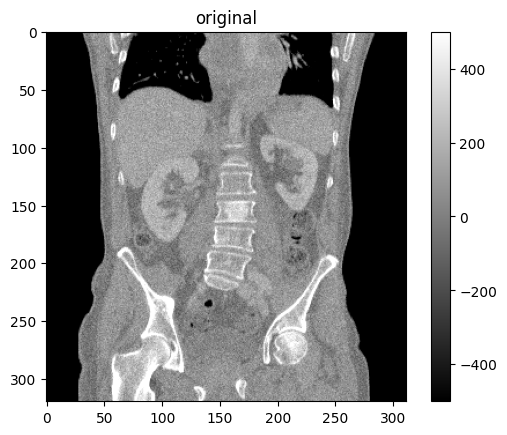

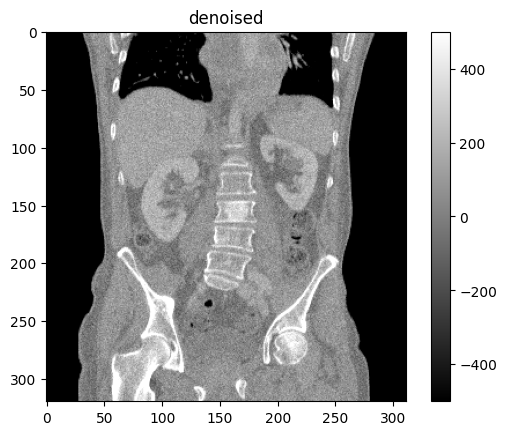

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(torch.clamp(img, -500, 500), 'gray')
plt.colorbar()
plt.title('original')
plt.show()
plt.imshow(torch.clamp(denoised_img.reshape(H, W), -500, 500), 'gray')
plt.colorbar()
plt.title('denoised')
plt.show()

# Task2: Denoising with Total Variation (TV) and Adam (8 pts)
In this task we will use the same image as in the previous task and try to denoise it using the total variation (TV) minimisation and optimisation with Adam.

The aim here is to find a denoised image $\mathbf{x}$ that minimises the following energy function:
$$
E(\mathbf{x}) = E_{fidelity}(x,y) + \lambda E_{\text{TV}}(\mathbf{x})
$$
where $\mathbf{y}$ is the noisy input image and $\lambda$ is a hyperparameter that controls the amount of TV regularisation.



First let's add some gaussian noise to the image:
$$
\mathbf{y} = \mathbf{x} + \mathcal{N}(0,\sigma^2)
$$
where $\sigma^2$ is the variance of the gaussian noise.

and visualize the noisy image:

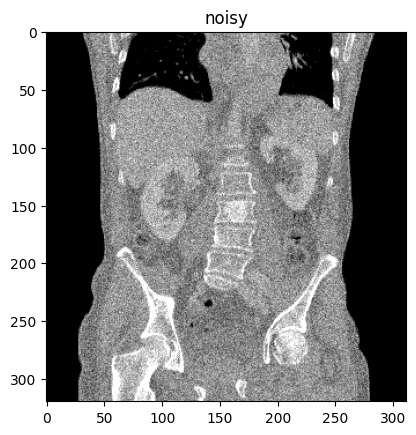

In [ ]:
def add_gaussian_noise(img, noise_level):
    return img + noise_level * torch.randn_like(img)

# add noise
sigma =  100
noisy_img = add_gaussian_noise(img, sigma)

plt.imshow(torch.clamp(noisy_img, -500, 500), 'gray')
plt.title('noisy')
plt.show()

Now let's define the TV regularizer as follows:
$L = \sum_{i,j} |\mathbf{x}_{i+1,j} - \mathbf{x}_{i,j}| + |\mathbf{x}_{i,j+1} - \mathbf{x}_{i,j}|$
where $\mathbf{x}_{i,j}$ is the pixel value at position $(i,j)$ in the image $\mathbf{x}$, which can be accessed by indexing the image.

Useful operations for this task are:
- `torch.abs` for computing the absolute value
- `torch.sum` for summing up the values of a tensor

In [ ]:
x = torch.tensor([[1,2,3],[0,0,0],[1,4,3]])
torch.diff(x, dim=1)

tensor([[ 1,  1],
        [ 0,  0],
        [ 3, -1]])

In [ ]:

# Todo: implement total variation regularization
def total_variation(x):
    # Todo: compute the absolute finite difference in x and y directions as dx and dy
    dx = torch.abs(torch.diff(x, dim=1)).view(-1)
    dy = torch.abs(torch.diff(x, dim=0)).view(-1)
    # Todo: compute the total variation
    tv_loss = torch.sum(dx) + torch.sum(dy)
    return tv_loss

Next we need to define the data fidelity term. For this purpose we will use the mean squared error (MSE) between the denoised image $\mathbf{x}$ and the noisy image $\mathbf{y}$:
$$
E_{fidelity}(\text{x},\text{y}) = \sum_{i,j} \left( \text{x}_{i,j} - \text{y}_{i,j} \right)^2
$$

Useful operations for this task are:
- `torch.pow` for computing the power of a tensor
- `torch.mean` for computing the mean of a tensor


In [ ]:
import torch.nn as nn

In [ ]:
def data_fidelity(x, y):
    # Todo: compute the data fidelity (1 pt)
    #data_fidelity_loss = torch.mean(torch.pow((x-y),2))
    loss = nn.MSELoss()
    data_fidelity_loss = loss(x,y)
    return data_fidelity_loss

Now that we defined the losses, we can start with the optimisation. For this purpose we will use the Adam optimiser. The Adam optimiser is a gradient descent method that uses adaptive momentum. We will use it to update the image $\mathbf{x}$ iteratively.

We do not need to compute the gradients and update the image ourselves. Instead we can use the `torch.optim.Adam` class.

In [ ]:

# Todo: initialize denoised_image x with zeros, it has the same shape as the noisy image and it requires grad computation
denoised_img = torch.zeros(img.shape, requires_grad=True)

# Todo: implement the Adam optimizer
optimizer = torch.optim.Adam([denoised_img], lr=10)

Finally, we can start the denoising for a given number of epochs. In each epoch we will compute the total variation and data fidelity loss and add them together to obtain the total loss. After the loss computation we can call `loss.backward()` to compute the gradients and `optimizer.step()` to update the image $\mathbf{x}$.

In [ ]:
# number of iterations
num_iterations = 1000

# given: denoising with total variation regularization
# try different values for lambda_tv -> what happens if you set it to 0? and what happens for large values?
lambda_tv = 0

# denoise image with total variation regularization
for i in trange(num_iterations, desc='TV + Adam Denoising'):
    # Todo: reset the gradient
    optimizer.zero_grad()

    # Todo: calculate the losses
    # data fidelity term
    loss_fidelity = data_fidelity(denoised_img, noisy_img)
    # total variation term
    loss_tv = total_variation(denoised_img)

    loss = loss_fidelity + lambda_tv * loss_tv

    # Pytorch automatically computes the gradient of the loss function and updates the denoised image
    # Todo: compute the gradients of the loss function
    loss.backward()
    # Todo: optimize the denoised image
    optimizer.step()

TV + Adam Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

TV + Adam Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Let's visualize the denoised image:

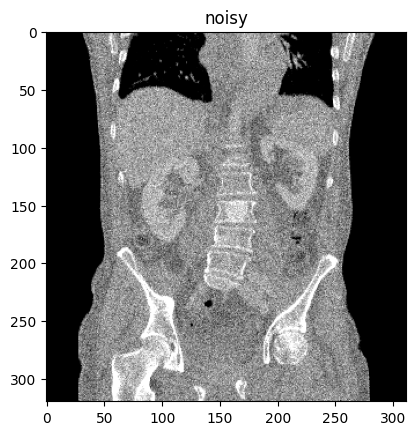

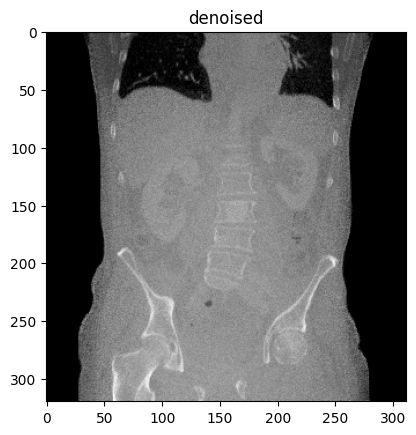

In [ ]:
plt.imshow(torch.clamp(noisy_img.detach(), -500, 500), 'gray')
plt.title('noisy')
plt.show()
plt.imshow(torch.clamp(denoised_img.detach(), -500, 500), 'gray')
plt.title('denoised')
plt.show()

## Bonus task: Bilateral Grid (4 pts)
With the bilateral grid the bilateral filter can be accelerated under certain conditions. This is much faster than a naive implementation if the following assumptions are made:
1. Gaussian filter is approximated by a fast rectangular filtering (dimensions separated, recursive mean value)
2. The grid is built with 16 quantisation layers.

We normalise the input image (ct_image_pytorch.pth) using `torch.clamp(img+500,0,1200)/1200`.

In [ ]:
I = torch.load('ct_image_pytorch.pth').add(500).clamp(0, 1200).div(1200)

For the implementation of the bilateral grid the function `torch.nn.functional.avg_pool2d` can be used (applying it twice with `kernel_size=11, stride=1, padding=5` is sufficient as approximation of the Gaussian filter). You can use `torch.linspace(0,1,16).view(1,-1,1,1)` to obtain a vector with $a=16$ quantisation levels. All layers of the 3D bilateral grid and the corresponding weight tensor can be computed in parallel (the 16 quantisation levels are in the channel dimension). The filter weights $w(a,y)$ which depend on the considered intensity values $a$ (from your quantization levels). For the second tensor $I_A(a,y)$ the respective filter weight is multiplied by the image intensity:
$$\begin{align}
w(a,y)&=\exp\left(-\frac{(a-I(y))^2}{2\sigma^2_I}\right)\\
I_A(a,y)&=w(a,y)I(y)
\end{align}$$


These multi-channel images are smoothed (using avg_pool2d). In the last step, the output value $I’(x)$ is calculated as a quotient of the filter results $I’_A/w’$, and the correct 3D position is selected (the Slicing) for those x for which $a \approx I(x)$ applies. You can use the command `torch.gather` for this purpose and obtain the required index tensor using `torch.argmax` on the weight tensor.  Test the method using $\sigma_I = 0.05$.

In [ ]:
# Todo

I_prime = # Todo

In [ ]:
plt.imshow(I.squeeze(), 'gray')
plt.title('original')
plt.show()
plt.imshow(I_prime.squeeze(), 'gray')